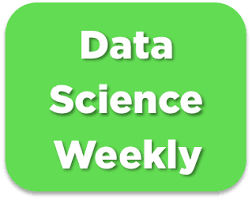

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


import kaleido
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
# pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [3]:
df_conv = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', df_conv.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
df_conv.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [6]:
print("Percentage of missing values: ")
display(100*df_conv.isnull().sum()/df_conv.shape[0])

Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [7]:
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [8]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = df_conv.sample(10000)

In [9]:
# Distribution of target
fig = px.histogram(data_sample, x = "converted")
fig.show()

In [10]:
# Distribution of target
fig = px.histogram(data_sample, x = "total_pages_visited")
fig.show()

In [11]:
# Distribution of target
fig = px.histogram(data_sample, x = "age")
fig.show()

In [12]:
# Bivariate analysis
# Distribution of each variable
num_features = data_sample.columns[:-1]
for f in num_features:
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()

In [13]:
# Correlation matrix
corr_matrix = data_sample.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets

In [14]:
features_list = ['country',	 'new_user', 'source','total_pages_visited', 'age']
target_variable = 'converted'

In [15]:
X = df_conv.loc[:, features_list]
Y = df_conv.loc[:, target_variable]

print('Explanatory variables : ', X.columns)


Explanatory variables :  Index(['country', 'new_user', 'source', 'total_pages_visited', 'age'], dtype='object')


In [16]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [17]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features
numeric_features = ['age', 'new_user', 'total_pages_visited'] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['country','source'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

Encoding categorical features and standardizing numerical features...


In [18]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [19]:
# Train model
print("Train model...")

classifier = LogisticRegression()
# classifier = LogisticRegression() # 

classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


## Predictions

In [20]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")

Predictions on training set...
...Done.
Predictions on test set...
...Done.


## Performance assessment

In [21]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7642058764473596
f1-score on test set :  0.7595396729254997


baseline model reaches a f1-score of almost 76%.

In [22]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246890    970]
 [  2553   5709]]

Confusion matrix on test set : 
[[27434   106]
 [  291   627]]



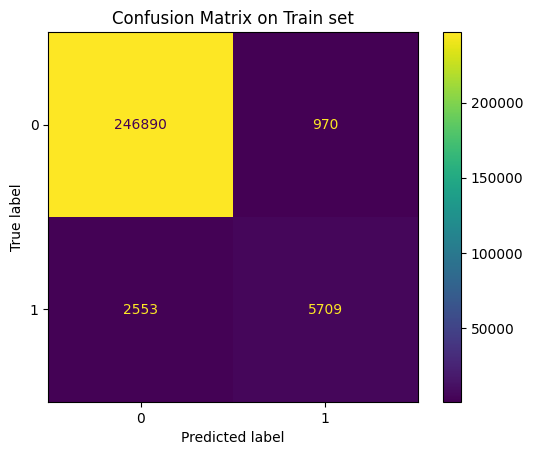

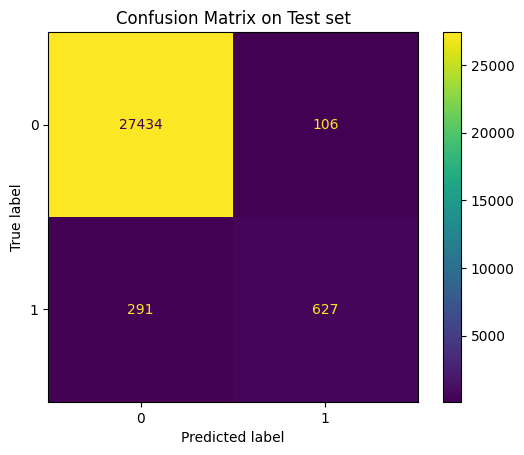

In [23]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

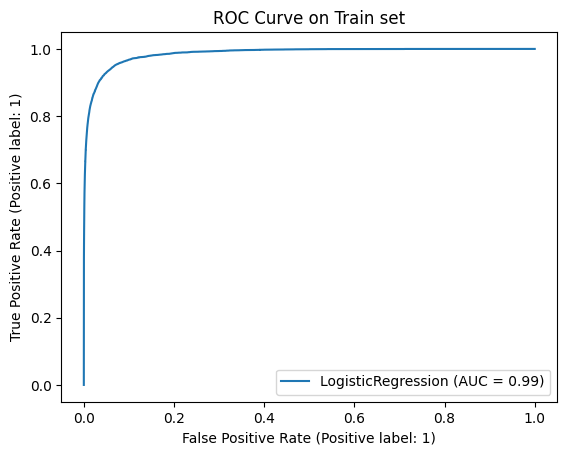

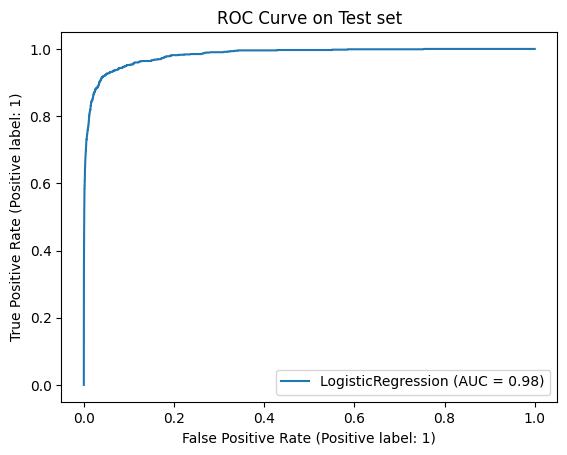

In [24]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

In [25]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_[:2]: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['age', 'new_user', 'total_pages_visited', 'x0_Germany', 'x0_UK', 'x0_US', 'x1_Direct', 'x1_Seo']


In [26]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = classifier.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
age,-0.603163
new_user,-0.799485
total_pages_visited,2.548266
x0_Germany,3.628997
x0_UK,3.429143
x0_US,3.073441
x1_Direct,-0.207869
x1_Seo,-0.043527


In [27]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
x1_Seo,0.043527
x1_Direct,0.207869
age,0.603163
new_user,0.799485
total_pages_visited,2.548266
x0_US,3.073441
x0_UK,3.429143
x0_Germany,3.628997


In [28]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

In [29]:
# Perform grid search
print("Grid search...")
# Grid of values to be tested
params = {
    'C': [ 1, 5, 10.0, 15, 20] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5, scoring ="f1") # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best f1 score : ", gridsearch.best_score_)

print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
...Done.
Best hyperparameters :  {'C': 15}
Best f1 score :  0.7648523208782227
f1 score on training set :  0.7642178509300147
f1 score on test set :  0.7598306110102844


**Our baseline model reaches a f1-score of almost 76%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

In [30]:
classifier = RandomForestClassifier()

# Perform grid search
print("Grid search...")
# Grid of values to be tested
# Grid of values to be tested
params = {
    'max_depth': [ 10, 12, 14],
    'min_samples_leaf': [ 5, 6, 7],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [25, 30, 35]
}

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best f1 score : ", gridsearch.best_score_)

print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 35}
Best f1 score :  0.7589605561442502
f1 score on training set :  0.7740723344293096
f1 score on test set :  0.7518072289156628


In [31]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best f1 score : ", gridsearch.best_score_)

print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 35}
Best f1 score :  0.7589605561442502
f1 score on training set :  0.7740723344293096
f1 score on test set :  0.7518072289156628


Performances

In [32]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")

print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()


Predictions on training set...
...Done.
Predictions on test set...
...Done.
f1-score on training set :  0.7740723344293096
f1-score on test set :  0.7518072289156628



## Bagging with logistic regression as base estimator

In [33]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [ 3, 4, 5.0, 6, 7], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [2, 3, 4, 5, 6] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [3, 4, 5.0, 6, 7], 'n_estimators': [2, 3, 4, 5, 6]}
...Done.
Best hyperparameters :  {'base_estimator__C': 6, 'n_estimators': 3}
Best validation f1 score :  0.764633838253312

f1 score on training set :  0.7642146054653571
f1 score on test set :  0.7584541062801932


## Bagging with decision tree as base estimator

In [34]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [5, 10, 15, 20],
    'base_estimator__min_samples_leaf': [2, 3, 4, 5],
    'base_estimator__min_samples_split': [5, 6, 7, 8, 10],
    'n_estimators': [4, 5, 6]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [5, 10, 15, 20], 'base_estimator__min_samples_leaf': [2, 3, 4, 5], 'base_estimator__min_samples_split': [5, 6, 7, 8, 10], 'n_estimators': [4, 5, 6]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 4, 'base_estimator__min_samples_split': 6, 'n_estimators': 5}
Best validation f1 score :  0.7545748443608208

f1 score on training set :  0.7741504773349355
f1 score on test set :  0.7488038277511961


## Adaboost with logistic regression as base estimator

In [35]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [15.0, 20.0, 25.0], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [50, 100, 200] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [15.0, 20.0, 25.0], 'n_estimators': [50, 100, 200]}
...Done.
Best hyperparameters :  {'base_estimator__C': 20.0, 'n_estimators': 50}
Best validation f1 score :  0.7656092979842838

f1 score on training set :  0.7655979779167221
f1 score on test set :  0.758248350329934


## Adaboost with decision tree as base estimator

In [36]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [5, 10, 15, 20],
    'base_estimator__min_samples_leaf': [2, 3, 4, 5],
    'base_estimator__min_samples_split': [5, 6, 7, 8, 10],
    'n_estimators': [4, 5, 6]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [5, 10, 15, 20], 'base_estimator__min_samples_leaf': [2, 3, 4, 5], 'base_estimator__min_samples_split': [5, 6, 7, 8, 10], 'n_estimators': [4, 5, 6]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 4, 'base_estimator__min_samples_split': 10, 'n_estimators': 5}
Best validation f1 score :  0.762288761024231

f1 score on training set :  0.7655464408573696
f1 score on test set :  0.7549194991055457


## Boosting with decision tree as base estimator

In [37]:
# Perform grid search
print("Grid search...")
model = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [5, 10, 15], # no base_estimator_ prefix because these are all arguments of GradientBoostingClassifier
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5,  8, 10],
    'n_estimators': [4, 5, 6, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'max_depth': [5, 10, 15], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [5, 8, 10], 'n_estimators': [4, 5, 6, 10]}
...Done.
Best hyperparameters :  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
Best validation f1 score :  0.7177156087289381

f1 score on training set :  0.7261302903365593
f1 score on test set :  0.7201034259857789


## XGBoost

In [38]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [5, 6, 7], # exactly the same role as in scikit-learn
    'min_child_weight': [2, 3, 4], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [ 10, 15, 20, 25, 30] # exactly the same role as in scikit-learn
}
print(params)
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3, scoring ="f1", n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation f1 score : ", gridsearch.best_score_)
print()
print("f1 score on training set : ", gridsearch.score(X_train, Y_train))
print("f1 score on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'max_depth': [5, 6, 7], 'min_child_weight': [2, 3, 4], 'n_estimators': [10, 15, 20, 25, 30]}
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 25}
Best validation f1 score :  0.763742539150232

f1 score on training set :  0.7697494546175714
f1 score on test set :  0.7556615017878427


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [41]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier()

In [42]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [43]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...


NameError: name 'featureencoder' is not defined

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**